### KNN Algorithm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter

In [4]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']

In [5]:
df

,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


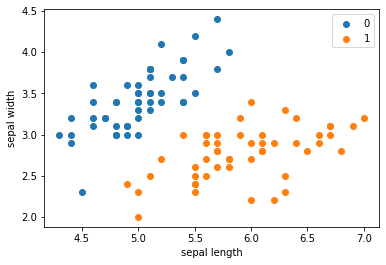

In [6]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [7]:
data = np.array(df.iloc[:100, [0, 1, -1]])
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
class KNN:
    def __init__(self, X_train, y_tarin, n_neighbors=3, p=2) -> None:
        self.n = n_neighbors
        self.p = p
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X):
        knn_list = []
        # 初始化：头n个数据
        for i in range(self.n):
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p) # 求范数，距离的度量 https://blog.csdn.net/hqh131360239/article/details/79061535
            knn_list.append((dist, self.y_train[i]))
        # 遍历，每次都将n个数据中最大的换掉，最后得到全部数据中最小的的n个
        for i in range(self.n, len(self.X_train)):
            max_index = knn_list.index(max(knn_list, key=lambda x: x[0])) # knn_list是元组，依据dist进行排序，选出最大的即max_index初始化为距离最远的点
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
            if knn_list[max_index][0] > dist:
                knn_list[max_index] = (dist, self.y_train[i])
        
        # 统计
        knn = [k[-1] for k in knn_list]
        count_pairs = Counter(knn)
        # Counter的返回对象是元组的列表 https://realpython.com/python-counter/
        max_count = sorted(count_pairs.items(), key=lambda x : x[1])[-1][0]
        return max_count

    def score(self, X_test, y_test):
        right_count = 0
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            if label == y:
                right_count += 1
        return right_count / len(X_test)

In [9]:
clf = KNN(X_train, y_train)

In [10]:
clf.score(X_test, y_test)

1.0

That's why KNN is a lazy learning algorithm: training data only be used when there is a test

直观理解

In [11]:
test_point = [6.0, 3.0]
print('Test Point: {}'.format(clf.predict(test_point)))

Test Point: 1.0


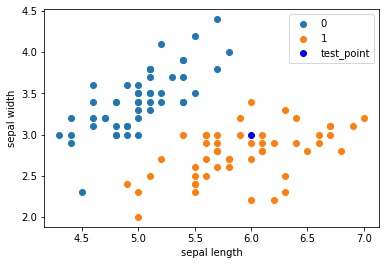

In [12]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.plot(test_point[0], test_point[1], 'bo', label='test_point')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

### 平衡 kd-tree

平衡kd tree搜索时未必是最优的

In [13]:
class KdNode(object):
    def __init__(self, dom_elt, split, left, right) -> None:
        self.dom_elt = dom_elt  # k维向量节点(k维空间中的一个样本点)
        self.split = split  # 整数（进行分割维度的序号）
        self.left = left  # 该结点分割超平面左子空间构成的kd-tree
        self.right = right  # 该结点分割超平面右子空间构成的kd-tree

class KdTree(object):
    def __init__(self, data) -> None:
        k = len(data[0]) # 数据维度
    
        def CreateNode(split, data_set):
            # 按第split维划分数据集exset创建KdNode
            if not data_set: # 数据集为空
                return None
            data_set.sort(key=lambda x: x[split])
            split_pos = len(data_set) // 2
            median = data_set[split_pos] # 中位数分割点
            split_next = (split + 1) % k # cycle coordinates

            #递归创建kd树
            return KdNode(
                median, 
                split,
                CreateNode(split_next, data_set[:split_pos]), # 创建左子树
                CreateNode(split_next, data_set[split_pos + 1:]) # 创建右子树
            )
            
        self.root = CreateNode(0, data) # 从第0维分量开始构建kd树，返回根节点
# KDTree的前序遍历
def preorder(root):
    print(root.dom_elt)
    if root.left:
        preorder(root.left)
    if root.right:
        preorder(root.right)

In [14]:
# 对构建好的kd树进行搜索，寻找与目标点最近的样本点
from math import sqrt
from collections import namedtuple # https://www.runoob.com/note/25726

result = namedtuple("Result_tuple", ["nearest_point", "nearest_dist", "nodes_visited"])

def find_nearest(tree, point):
    k = len(point) # 数据维度

    def travel(kd_node, target, max_dist):
        if kd_node is None:
            return result([0]*k, float("inf"), 0) # python中用float("inf")和float("-inf")表示正负无穷
        
        nodes_visited = 1

        s = kd_node.split # 进行分割的维度
        pivot = kd_node.dom_elt # 进行分割的“轴”

        if target[s] <= pivot[s]: # 目标离左子树更近
            nearer_node = kd_node.left # 下一个访问节点为左子树根节点
            further_node = kd_node.right
        else : # 目标离右子树更近
            nearer_node = kd_node.right # 下一个访问节点为右子树根节点
            further_node = kd_node.left

        temp1 = travel(nearer_node, target, max_dist) # 进行遍历找到包含目标点的区域
        nearest = temp1.nearest_point # 此节点作为当前最近点
        dist = temp1.nearest_dist # 更新最近距离

        nodes_visited += temp1.nodes_visited
        
        if dist < max_dist:
            max_dist = dist # 最近点将在以目标点位球心，max_dist为半径的超球体内
        
        temp_dist = abs(pivot[s] - target[s]) # 第s维上目标点与分割超平面的距离
        if max_dist < temp_dist: # 判断超球体是否与超平面相交
            return result(nearest, dist, nodes_visited) # 不相交则可以直接返回，不用继续判断
        
        # 计算目标点与分割点的欧氏距离
        temp_dist = sqrt(sum((p1-p2)**2 for p1, p2 in zip (pivot, target)))

        if temp_dist < dist: # 如果“更近”
            nearest = pivot # 更新最近点
            dist = temp_dist # 更新最近距离
            max_dist = dist # 更新超球体半径
        
        # 检查另一个子节点对应的区域是否有更近的点
        temp2 = travel(further_node, target, max_dist)

        nodes_visited += temp2.nodes_visited
        if temp2.nearest_dist < dist: # 如果另一个子节点内存在更近距离
            nearest = temp2.nearest_point # 更新最近点
            dist = temp2.nearest_dist # 更新最近距离

        return result(nearest, dist, nodes_visited)
    return travel(tree.root, point, float('inf')) # 从根节点开始递归


例3.2

In [15]:
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = KdTree(data)
preorder(kd.root)

[7, 2]
[5, 4]
[2, 3]
[4, 7]
[9, 6]
[8, 1]


In [23]:
from time import perf_counter
from random import random

# 产生一个k维随机向量，每维分量值在0~1之间
def random_point(k):
    return [random() for _ in range(k)]
 
# 产生n个k维随机向量 
def random_points(k, n):
    return [random_point(k) for _ in range(n)]

In [24]:
ret = find_nearest(kd, [3,4.5])
print (ret)

Result_tuple(nearest_point=[2, 3], nearest_dist=1.8027756377319946, nodes_visited=4)


In [27]:
N = 400000
t0 = perf_counter()
kd2 = KdTree(random_points(3, N))            # 构建包含四十万个3维空间样本点的kd树
ret2 = find_nearest(kd2, [0.1,0.5,0.8])      # 四十万个样本点中寻找离目标最近的点
print ("time: {:.5f}s".format(perf_counter()-t0))
print (ret2)

time: 5.70312s
Result_tuple(nearest_point=[0.10233373639542276, 0.4927207996311235, 0.7952639874315196], nearest_dist=0.008992380031025026, nodes_visited=72)


习题3.1

In [28]:
%matplotlib inline
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

data = np.array([[5, 12, 1], [6, 21, 0], [14, 5, 0], [16, 10, 0], [13, 19, 0],
                 [13, 32, 1], [17, 27, 1], [18, 24, 1], [20, 20, 0], [23, 14, 1],
                 [23, 25, 1], [23, 31, 1], [26, 8, 0], [30, 17, 1],
                 [30, 26, 1], [34, 8, 0], [34, 19, 1], [37, 28, 1]])
X_train = data[:, 0:2]
y_train = data[:, 2]

models = (KNeighborsClassifier(n_neighbors=1, n_jobs=-1),
          KNeighborsClassifier(n_neighbors=2, n_jobs=-1))
models = (clf.fit(X_train, y_train) for clf in models)

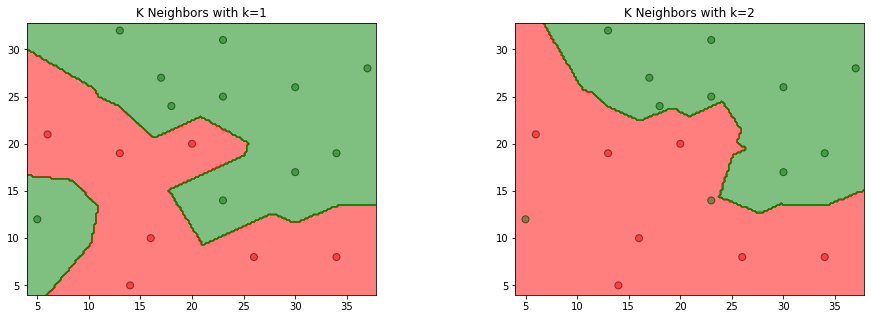

In [29]:
titles = ('K Neighbors with k=1', 'K Neighbors with k=2')

fig = plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_train[:, 0], X_train[:, 1]

x_min, x_max = X0.min() - 1, X0.max() + 1
y_min, y_max = X1.min() - 1, X1.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                     np.arange(y_min, y_max, 0.2))

for clf, title, ax in zip(models, titles, fig.subplots(1, 2).flatten()):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    colors = ('red', 'green', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(Z))])
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)
    ax.scatter(X0, X1, c=y_train, s=50, edgecolors='k', cmap=cmap, alpha=0.5)
    ax.set_title(title)

plt.show()

k越小模型越复杂，也越容易出现过拟合

### KNN in scikit-learn 

sklearn.neighbors.KNeighborsClassifier(n_neighbors, p, algorithm, weights)
+ n_neighbors: 临近点的个数
+ p: 距离度量（范数）
+ algorithm: 近邻算法，可选{auto, ball_tree, kd_tree, brute}
+ weights: 确定近邻的权重
https://blog.csdn.net/TeFuirnever/article/details/99818078

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
clf_sk = KNeighborsClassifier()
clf_sk.fit(X_train, y_train)

KNeighborsClassifier()

In [18]:
clf_sk.score(X_test, y_test)

1.0

different value of k 

https://towardsdatascience.com/knn-using-scikit-learn-c6bed765be75

In [30]:
from sklearn.datasets import load_iris

In [31]:
iris = load_iris()
type(iris)

sklearn.utils.Bunch

In [35]:
iris.data[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [36]:
print(iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [37]:
print(iris.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [38]:
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


In [39]:
print(type(iris.data))
print(type(iris.target))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [40]:
print(iris.data.shape)

(150, 4)


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [50]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
k_range = range(1, 80)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, y_pred)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

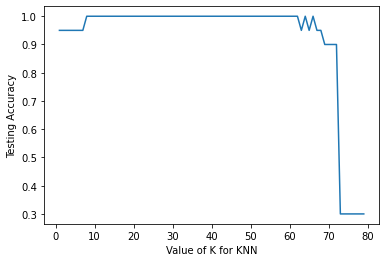

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(k_range, scores_list)
plt.xlabel("Value of K for KNN")
plt.ylabel('Testing Accuracy')